<a href="https://colab.research.google.com/github/Frank-III/Fin553-ML-in-Finance/blob/main/Jiangda_553_2022_Project_4_The_Merton_Portfolio_Choice_Problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install -q optax dm-haiku

     |████████████████████████████████| 154 kB 22.9 MB/s 
     |████████████████████████████████| 352 kB 55.7 MB/s 
     |████████████████████████████████| 85 kB 1.0 MB/s 


Due Date: December 7th
# Problem statement

Consider the stochastic cake-eating problem you solved in the previous assignment. Suppose that instead of investing the wealth entirely in the stock market, you have the option to assign a fraction $\alpha$ of your wealth in the stock market, and the remaining is invested in a risk-free savings account that pays a 1.04 % gross return. Notice that $\alpha$ is bounded below by 0, and bounded above by 1.

Solve for the optimal consumption ($c$) and asset allocation ($\alpha$).

- Print the average sum of discounted rewards (utilities) using 1 million simulations.
 
 - Plot the average consumption-wealth ratio ($c / x)$ for each time period $t=0, 1, ..., 49$

 - Plot the average asset allocation in the risky asset($\alpha)$ for each time period $t=0, 1, ..., 49$

Hint: Starting from the code of the previous assignment, the modifications you have to implement are minimal. Namely:

- The output of the neural network now should be a 2d vector, [link text](https://)corresponding to the consumption-wealth ratio (c / x) and $\alpha$, respectively


In [ ]:
import jax
import jax.numpy as jnp
import optax
import haiku as hk
import matplotlib.pyplot as plt


γ = 2.
β = 0.95
Rf = 1.04


def U(c):
    return c**(1 - γ) / (1 - γ)


optimizer = optax.adam
lr = 1e-3
T = 50
batch_size = 256
N = 10000   # #trainning


def nnet(x):
  X = jnp.column_stack([x])
  X = hk.Linear(32)(X)
  X = jnp.tanh(X)
  X = hk.Linear(2)(X)
  X = jnp.squeeze(X)
  return X


init, nnet = hk.without_apply_rng(hk.transform(nnet))
rng = jax.random.PRNGKey(0)
Θ = init(rng, jnp.ones(2))


opt_state = optimizer(lr).init(Θ)


def L(Θ, batch_size, rng):
  G = 0.
  μs = 0.06
  σs = 0.2
  state = jnp.ones(batch_size)
  stock_returns = jnp.exp(μs + σs * jax.random.normal(rng, (T, batch_size)))
  inputs = jnp.arange(T), stock_returns

  def core(state, inputs):
    t, R = inputs
    xt = state
    theta, α = jnp.hsplit(nnet(Θ, xt), 2)
    theta = jax.nn.sigmoid(theta.squeeze() - 4.)
    ct = theta * xt
    α = jax.nn.sigmoid(α.squeeze() - 4.)
    ut = U(ct)
    savings = xt - ct

    x_tp1 = R * savings * α + Rf * savings * (1 - α)
    discounted_utility = β**t * ut
    return x_tp1, discounted_utility.mean()

  state, discounted_utility = jax.lax.scan(core, state, inputs)
  G = discounted_utility.sum()
  return -G


@jax.jit
def evaluation(Θ):
  rng = jax.random.PRNGKey(0)
  G = L(Θ, 1000000, rng)
  return -G


@jax.jit
def update_gradient_descent(Θ, opt_state, rng):
  rng, _ = jax.random.split(rng)
  grad = jax.grad(L)(Θ, batch_size, rng)
  updates, opt_state = optimizer(lr).update(grad, opt_state)
  Θ = optax.apply_updates(Θ, updates)
  return Θ, opt_state, rng



rng = jax.random.PRNGKey(0)

for iteration in range(N):
  Θ, opt_state, rng = update_gradient_descent(Θ, opt_state, rng)

  if iteration % 1000 == 0:
    print(evaluation(Θ))
    

-1276.8472
-374.65567
-370.778
-369.9552
-369.729
-370.04797
-369.63974
-369.57214


KeyboardInterrupt: ignored

In [ ]:
def draw(Θ, batch_size):
  import matplotlib.pyplot as plt
  rng = jax.random.PRNGKey(0)
  G = 0.
  μs = 0.06
  σs = 0.2
  state = jnp.ones(batch_size)
  stock_returns = jnp.exp(μs + σs * jax.random.normal(rng, (T, batch_size)))
  inputs = jnp.arange(T), stock_returns

  def core(state, inputs):
    t, R = inputs
    xt = state
    theta, α = jnp.hsplit(nnet(Θ, xt), 2)
    theta = jax.nn.sigmoid(theta.squeeze() - 4.)
    ct = theta * xt
    α = jax.nn.sigmoid(α.squeeze() - 4.)
    ut = U(ct)
    savings = xt - ct

    x_tp1 = R * savings * α + Rf * savings * (1 - α)
    discounted_utility = β**t * ut
    return x_tp1, (discounted_utility.mean(), theta.mean(), α.mean())

  state, (discounted_utility, cw_ratio, α)  = jax.lax.scan(core, state, inputs)
  #G = discounted_utility.sum()
  fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18,8))
  ax1.plot(cw_ratio)
  ax1.set_title("average consumption-wealth ratio (c/w)")
  ax1.set_xlabel("period")
  ax1.set_ylabel("ratio")
  ax2.plot(α)
  ax2.set_title("average asset allocation in the risky asset(α)")
  ax2.set_xlabel("period")
  ax2.set_ylabel("allocation")
  return fig

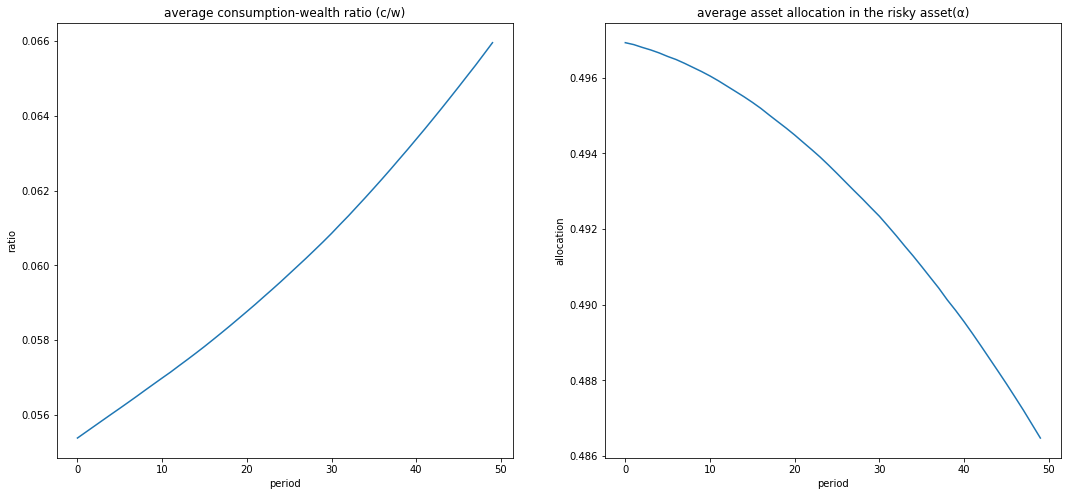

In [ ]:
draw(Θ, 100000);